In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
  ! gdown --id '1Zw9kScYqS_HtCop3s-MgbniUeECoyndI' --output ABIDE_alff.zip
  !unzip "/content/ABIDE_alff.zip"
  ! gdown --id '1rGLM-WsiwCsAqJowzq9X5ltKtImhAkoG' --output ABIDE_csv.zip
  !unzip "/content/ABIDE_csv.zip"

Fri May  5 07:58:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import torch
import os
import random
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn as nn
import nibabel as nib

import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset
import torchvision.models as models


multi-dataset

In [3]:
random.seed(3407)
rmb_label = {"ASD": 0, "TD": 1}      # 设置标签

class MultiModalDataset(Dataset):
    def __init__(self, data_dirnii , data_dircsv, transform=None):
        """ 
        ABIDE_db的Dataset
        :param data_dir: str, 数据集所在路径
        :param transform: torch.transform，数据预处理
        """
        self.label_name = {"ASD": 0, "TD": 1}
        self.data_infocsv = self.get_csv_info(data_dircsv)  # data_info存储所有txt路径和标签，在DataLoader中通过index读取样本
        self.data_infonii = self.get_nii_info(data_dirnii)  # data_info存储所有txt路径和标签，在DataLoader中通过index读取样本

        self.transform = transform
        random_index = random.randint(0, len(self.data_infonii))
        print(f'Number of samples:[csv:{len(self.data_infocsv)}]  [nii:{len(self.data_infonii)}]')
        print(f'Sample info:[index={random_index}]\n[csv:{self.data_infocsv[random_index]}\n[nii:{self.data_infonii[random_index]}]')

        
    def __getitem__(self, index):
        path_csv, label_csv = self.data_infocsv[index]
        path_nii, label_nii = self.data_infonii[index]
        txt_data = np.loadtxt(path_csv, delimiter=',')
        if label_csv != label_nii:
            print('Error: label not match!')
            print('the error nii:{}\n the error csv:{}',path_nii,path_csv)
        else: label = label_csv
        cor = torch.from_numpy(txt_data).float().unsqueeze(0)
        img = nib.load(path_nii).get_fdata()
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        
        if self.transform is not None:
            txt = 1   # 在这里做transform，转为tensor等等

        return img,cor, label

    def __len__(self):
        return len(self.data_infocsv)

    @staticmethod
    def get_csv_info(data_dir):
        data_infocsv = list()
        for root, dirs, _ in os.walk(data_dir):
            # 遍历类别
            for sub_dir in dirs:
                txt_names = os.listdir(os.path.join(root, sub_dir))
                txt_names = list(filter(lambda x: x.endswith('.csv'), txt_names))

                # 遍历txt
                for i in range(len(txt_names)):
                    txt_name = txt_names[i]
                    path_txt = os.path.join(root, sub_dir, txt_name)
                    label = rmb_label[sub_dir]
                    data_infocsv.append((path_txt, int(label)))
                    data_infocsv = sorted(data_infocsv)

        return data_infocsv
    
    def get_nii_info(self,data_dir):
        data_infonii = list()
        for root, dirs, _ in os.walk(data_dir):
            # 遍历类别
            for sub_dir in dirs:
                txt_names = os.listdir(os.path.join(root, sub_dir))
                txt_names = list(filter(lambda x: x.endswith('.nii.gz'), txt_names))

                # 遍历txt
                for i in range(len(txt_names)):
                    txt_name = txt_names[i]
                    path_txt = os.path.join(root, sub_dir, txt_name)
                    label = rmb_label[sub_dir]
                    data_infonii.append((path_txt, int(label)))
                    data_infonii = sorted(data_infonii)
        return data_infonii

# 3D-IMG 特征提取模型
- 改为特征提取

In [4]:
import torch
import torch.nn as nn

# 定义 3D 卷积块类
class My3DConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(My3DConvBlock, self).__init__()
        
        # 3D 卷积层
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        
        # 批量归一化层
        self.bn = nn.BatchNorm3d(out_channels)
        
        # ReLU 激活函数
        self.relu = nn.ReLU(inplace=True)
        
        # 注意力机制（用于计算权重系数）
        self.attention = nn.Sequential(
            nn.Linear(out_channels, out_channels // 4),
            nn.ReLU(inplace=True),
            nn.Linear(out_channels // 4, out_channels),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        
        # 计算注意力权重系数
        attention_weight = self.attention(torch.mean(x, dim=(2,3,4)))
        attention_weight = attention_weight.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        
        # 乘上注意力权重系数
        x = x * attention_weight
        
        return x

class FeatureExtractor3DCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractor3DCNN, self).__init__()
        
        # 3D convolution block 1
        self.conv_block1 = My3DConvBlock(1, 32, kernel_size=3, stride=1, padding=1)
        
        # 3D pooling layer
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        # 3D convolution block 2
        self.conv_block2 = My3DConvBlock(32, 64, kernel_size=3, stride=1, padding=1)
        
        # 3D pooling layer
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.pool1(x)
        x = self.conv_block2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        return x


# csv特征提取模型
- 改为提取特征

In [5]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            DoubleConv(in_channels, out_channels),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
    
class FeatureExtractorCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            Down(1, 8),
            Down(8, 16),
            Down(16, 32)
        )
        self.fc1 = nn.Linear(32 * 14 * 14 ,128)
    def forward(self, x):
        x = self.encoder(x)
        # print("Shape after encoder:", x.shape)
        x = x.view(-1, 32 * 14 * 14 )
        x = F.relu(self.fc1(x))
        return x


In [ ]:
# class FeatureExtractorCNN(nn.Module):
#     def __init__(self):
#         super(FeatureExtractorCNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.fc1 = nn.Linear(32 * 29 * 29, 128)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 32 * 29 * 29)
#         x = F.relu(self.fc1(x))
#         return x

In [6]:
class MultiModalClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(MultiModalClassifier, self).__init__()
        self.feature_extractor_3d = FeatureExtractor3DCNN()
        self.feature_extractor_gray = FeatureExtractorCNN()

        # Fully connected layer to combine the features from both extractors and perform classification
        self.classifier = nn.Sequential(
            nn.Linear(128 + 64 * 15 * 18 * 15, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x_3d, x_gray):
        features_3d = self.feature_extractor_3d(x_3d)
        features_gray = self.feature_extractor_gray(x_gray)

        # Concatenate the features from both extractors
        combined_features = torch.cat((features_3d, features_gray), dim=1)

        # Pass the combined features through the classifier
        output = self.classifier(combined_features)
        return output


# 训练

In [7]:
root_dir_3d = '/content/alff_split_1'
csvsplit_dir = os.path.join('/content/csv_split_1')  
csvtrain_dir = os.path.join(csvsplit_dir, "train")
csvvalid_dir = os.path.join(csvsplit_dir, "valid")
csvtest_dir  = os.path.join(csvsplit_dir, "test") 
niisplit_dir = os.path.join('/content/alff_split_1')  
niitrain_dir = os.path.join(niisplit_dir, "train")
niivalid_dir = os.path.join(niisplit_dir, "valid")
niitest_dir  = os.path.join(niisplit_dir, "test") 

In [ ]:
import torch
torch.cuda.empty_cache()

Number of samples:[csv:593]  [nii:593]
Sample info:[index=58]
[csv:('/content/csv_split_1/train/ASD/NYU_0050956.csv', 0)
[nii:('/content/alff_split_1/train/ASD/NYU_0050956.nii.gz', 0)]
Number of samples:[csv:170]  [nii:170]
Sample info:[index=107]
[csv:('/content/csv_split_1/valid/TD/NYU_0051105.csv', 1)
[nii:('/content/alff_split_1/valid/TD/NYU_0051105.nii.gz', 1)]
Number of samples:[csv:86]  [nii:86]
Sample info:[index=16]
[csv:('/content/csv_split_1/test/ASD/OHSU_0050148.csv', 0)
[nii:('/content/alff_split_1/test/ASD/OHSU_0050148.nii.gz', 0)]
训练
Epoch [1/50], Train Loss: 17.3660, Train Accuracy: 0.4823, Validation Loss: 1.4654, Validation Accuracy: 0.5353
Epoch [2/50], Train Loss: 1.6875, Train Accuracy: 0.4958, Validation Loss: 0.9851, Validation Accuracy: 0.5118
Epoch [3/50], Train Loss: 0.8203, Train Accuracy: 0.5346, Validation Loss: 0.8942, Validation Accuracy: 0.4647
Epoch [4/50], Train Loss: 0.7747, Train Accuracy: 0.5160, Validation Loss: 0.9879, Validation Accuracy: 0.5118


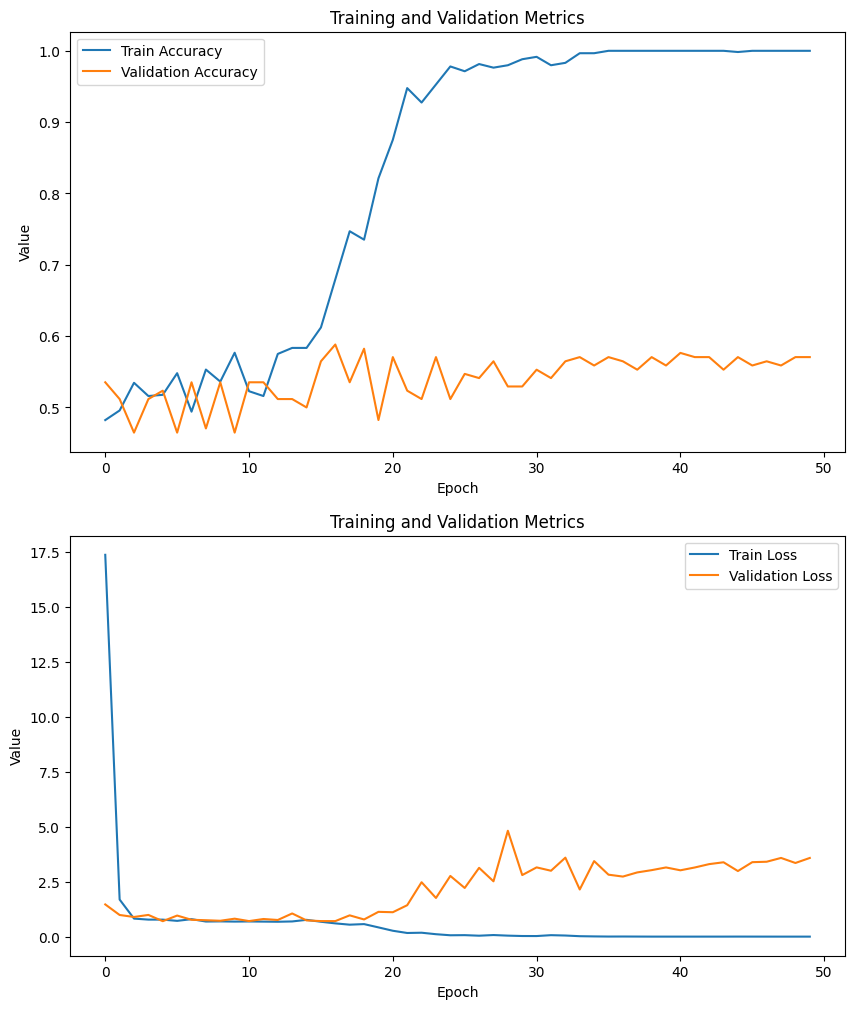

In [8]:
# 定义超参数
input_size = [116,116]
batch_size = 32
learning_rate = 0.001
num_epochs = 50
num_classes = 2
log_interval = 8
val_interval = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiModalClassifier()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)     # 设置学习率下降策略

# 实例化数据集和数据加载器

train_dataset = MultiModalDataset(niitrain_dir,csvtrain_dir, transform=None)
valid_dataset = MultiModalDataset(niivalid_dir, csvvalid_dir, transform=None)
test_dataset = MultiModalDataset(niitest_dir, csvtest_dir, transform=None)
#CNN 图像模型dataloader
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn = collate_fn,num_workers = num_workers)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,collate_fn = collate_fn,num_workers = num_workers)
#非CNN 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

print('训练')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
# ============================ step 5/5 训练 ============================
# 训练和验证
for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (images_3d, images_gray, label) in enumerate(train_loader):
        images_3d, images_gray, label = images_3d.to(device), images_gray.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = model(images_3d, images_gray)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images_gray.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # 验证阶段
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        total = 0
        correct = 0
        for images_3d, images_gray, label in valid_loader:
            images_3d, images_gray, label = images_3d.to(device), images_gray.to(device), label.to(device)
            outputs = model(images_3d, images_gray)
            loss = criterion(outputs, label)
            running_loss += loss.item() * images_gray.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            # pred = outputs.argmax(dim=1)
            # print(f"Sample: predicted={pred.item()}, target={label.item()},matched?={label.item() == pred.item()}")

    valid_loss = running_loss / len(valid_dataset)
    valid_acc = correct / total
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    # 打印训练过程中的指标
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")


# 绘制训练和验证指标的图表
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
axs[0].plot(train_accs, label='Train Accuracy')
axs[0].plot(valid_accs, label='Validation Accuracy')
axs[0].legend()
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Value')
axs[0].set_title('Training and Validation Metrics')

axs[1].plot(train_losses, label='Train Loss')
axs[1].plot(valid_losses, label='Validation Loss')
axs[1].legend()
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Value')
axs[1].set_title('Training and Validation Metrics')

plt.show()

Number of samples:[csv:593]  [nii:593]
Sample info:[index=250]
[csv:('/content/csv_split_1/train/ASD/USM_0050515.csv', 0)
[nii:('/content/alff_split_1/train/ASD/USM_0050515.nii.gz', 0)]
Number of samples:[csv:170]  [nii:170]
Sample info:[index=121]
[csv:('/content/csv_split_1/valid/TD/Pitt_0050051.csv', 1)
[nii:('/content/alff_split_1/valid/TD/Pitt_0050051.nii.gz', 1)]
Number of samples:[csv:86]  [nii:86]
Sample info:[index=65]
[csv:('/content/csv_split_1/test/TD/Pitt_0050037.csv', 1)
[nii:('/content/alff_split_1/test/TD/Pitt_0050037.nii.gz', 1)]
训练
Epoch [1/50], Train Loss: 10.9512, Train Accuracy: 0.5025, Validation Loss: 4.0655, Validation Accuracy: 0.5118
Epoch [2/50], Train Loss: 2.8023, Train Accuracy: 0.5110, Validation Loss: 7.3638, Validation Accuracy: 0.5118
Epoch [3/50], Train Loss: 3.3531, Train Accuracy: 0.4924, Validation Loss: 1.9791, Validation Accuracy: 0.5118
Epoch [4/50], Train Loss: 1.5073, Train Accuracy: 0.5261, Validation Loss: 1.1082, Validation Accuracy: 0.5294

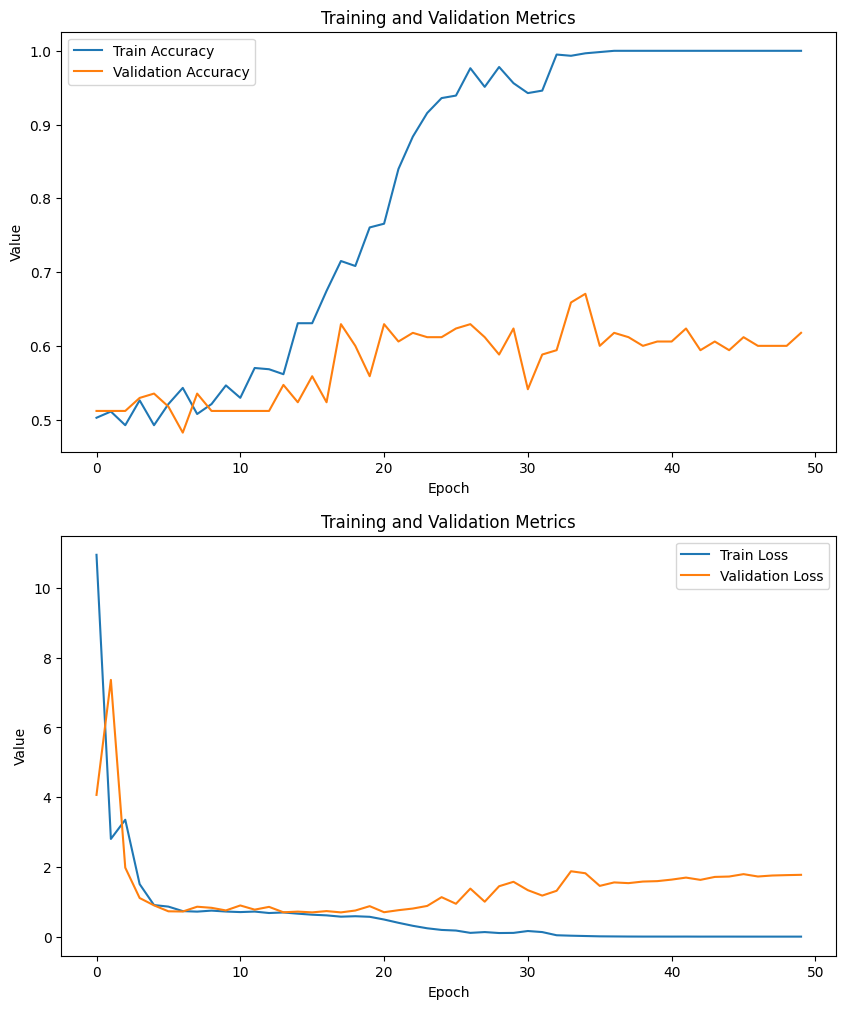

In [ ]:
# simple CNN 
# 定义超参数
input_size = [116,116]
batch_size = 32
learning_rate = 0.001
num_epochs = 50
num_classes = 2
log_interval = 8
val_interval = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiModalClassifier()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)     # 设置学习率下降策略

# 实例化数据集和数据加载器

train_dataset = MultiModalDataset(niitrain_dir,csvtrain_dir, transform=None)
valid_dataset = MultiModalDataset(niivalid_dir, csvvalid_dir, transform=None)
test_dataset = MultiModalDataset(niitest_dir, csvtest_dir, transform=None)
#CNN 图像模型dataloader
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn = collate_fn,num_workers = num_workers)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,collate_fn = collate_fn,num_workers = num_workers)
#非CNN 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

print('训练')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
# ============================ step 5/5 训练 ============================
# 训练和验证
for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (images_3d, images_gray, label) in enumerate(train_loader):
        images_3d, images_gray, label = images_3d.to(device), images_gray.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = model(images_3d, images_gray)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images_gray.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # 验证阶段
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        total = 0
        correct = 0
        for images_3d, images_gray, label in valid_loader:
            images_3d, images_gray, label = images_3d.to(device), images_gray.to(device), label.to(device)
            outputs = model(images_3d, images_gray)
            loss = criterion(outputs, label)
            running_loss += loss.item() * images_gray.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            # pred = outputs.argmax(dim=1)
            # print(f"Sample: predicted={pred.item()}, target={label.item()},matched?={label.item() == pred.item()}")

    valid_loss = running_loss / len(valid_dataset)
    valid_acc = correct / total
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    # 打印训练过程中的指标
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")


# 绘制训练和验证指标的图表
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
axs[0].plot(train_accs, label='Train Accuracy')
axs[0].plot(valid_accs, label='Validation Accuracy')
axs[0].legend()
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Value')
axs[0].set_title('Training and Validation Metrics')

axs[1].plot(train_losses, label='Train Loss')
axs[1].plot(valid_losses, label='Validation Loss')
axs[1].legend()
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Value')
axs[1].set_title('Training and Validation Metrics')

plt.show()

In [ ]:
model_save_path = "model.pth"
torch.save(model.state_dict(), model_save_path)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat

class SelfAttention(nn.Module):
    def __init__(self, dim0=128): # dim0 should be the channel number of each input, i.e., x1, x2, x3,...
        super().__init__()
        self.attend = nn.Softmax(dim=-1)
        self.scale = dim0 ** -0.5

    def forward(self, x1, x2, x3, x4):
        # the shape of x1, x2, x3,... is (b 1 d)
        x = torch.cat((x1, x2, x3, x4), 1) # the shape of x is (b 4 d)
        dots = torch.matmul(x, x.transpose(-1, -2)) * self.scale
        attn = self.attend(dots) # the shape of x is (b, 4, 4)
        importance = torch.sum(attn, dim=1) # the shape of importance is (b, 4)
        x = x * importance[:, :, None]
        x = x.view(x.shape[0], -1) # this can be sended into your classifer
        return x

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
 
        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)
 
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x): 
        # the shape of x is (b c h w)
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        attn = self.sigmoid(out) # (b c)
        x = x * attn[:, :, None, None]
        return x

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
 
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
 
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x): 
        # the shape of x is (b c h w)
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        attn = torch.cat([avg_out, max_out], dim=1)
        attn = self.conv1(attn) # b 1 h w
        attn = self.sigmoid(attn)
        attn = torch.squeeze(attn, dim=1) # b h w
        x = attn[:, None, :, :] * x
        return x